# Waste Object Detection (Tensorflow)

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [0]:
# If you forked the repository, you can replace the link.
#repo_url = 'https://github.com/Tony607/object_detection_demo'
repo_url = 'https://github.com/nandini9cs230/cs230_trash_object_detection_data'

# Number of training steps.
num_steps = 5000  # 200000

# Number of evaluation steps.
num_eval_steps = 250

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `object_detection_demo` repository or your fork.

In [0]:
import os
!pwd
%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

/content/models/research
/content
fatal: destination path 'cs230_trash_object_detection_data' already exists and is not an empty directory.
/content/cs230_trash_object_detection_data


## Install required packages

In [0]:
%cd /content
!rm -rf models
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.8: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rc

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file
python xml_to_csv.py -i images/train_set -o annotations/train_labels.csv -l annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i images/test_set -o annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=annotations/train_labels.csv --output_path=annotations/train.record --img_path=images/train_set --label_map annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=annotations/test_labels.csv --output_path=annotations/test.record --img_path=images/test_set --label_map annotations/label_map.pbtxt
```

In [0]:
%cd {repo_dir_path}
!pwd
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python ./xml_to_csv.py -i images/train_set -o annotations/train_labels.csv -l annotations

# Convert test folder annotation xml files to a single csv.
!python ./xml_to_csv.py -i images/val_set -o annotations/val_labels.csv

# Generate `train.record`
!python ./generate_tfrecord.py --csv_input=annotations/train_labels.csv --output_path=annotations/train.record --img_path=images/train_set --label_map annotations/label_map.pbtxt

# Generate `test.record`
!python ./generate_tfrecord.py --csv_input=annotations/val_labels.csv --output_path=annotations/val.record --img_path=images/val_set --label_map annotations/label_map.pbtxt

/content/cs230_trash_object_detection_data
/content/cs230_trash_object_detection_data
Successfully converted xml to csv.
Generate `annotations/label_map.pbtxt`
Successfully converted xml to csv.


W1103 23:48:59.731824 140135546414976 module_wrapper.py:139] From ./generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1103 23:48:59.865534 140135546414976 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/cs230_trash_object_detection_data/annotations/train.record


W1103 23:49:23.169502 140232108431232 module_wrapper.py:139] From ./generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1103 23:49:23.200292 140232108431232 module_wrapper.py:139] From /content/models/research/object_detect

In [0]:
val_record_fname = '/content/cs230_trash_object_detection_data/annotations/val.record'
train_record_fname = '/content/cs230_trash_object_detection_data/annotations/train.record'
label_map_pbtxt_fname = '/content/cs230_trash_object_detection_data/annotations/label_map.pbtxt'

## Download base model

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 70 root   root 4.0K Nov  3 23:55 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
print(pipeline_fname)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config


In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
print(num_classes)
with open(pipeline_fname) as f:
    s = f.read()
    print(s)
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    print("*************************")
    print(s)
    f.write(s)

6
# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 37
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        

In [0]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 6
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [0]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-11-03 23:56:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.221.209.32, 3.219.64.173, 54.236.200.27, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.221.209.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.63MB/s    in 2.0s    

2019-11-03 23:56:32 (6.63 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [55]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


## Train the model

In [53]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1103 23:58:20.231070 140262454925184 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1103 23:58:20.236628 140262454925184 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1103 23:58:20.236816 140262454925184 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W1103 23:58:20.237005 140262454925184 module_wrapper.py:139] From /content/models/res

**Interrupted training early as the model reached our expected baseline loss of ~1.0 : Loss = 1.0686216 at step 2000**

In [98]:
!ls /content/models/research/training
!cp -r {pipeline_fname} "/content/drive/My Drive/Waste_Object_Detection/"

checkpoint
eval_0
events.out.tfevents.1572825542.c6cc837e3e77
graph.pbtxt
model.ckpt-1268.data-00000-of-00001
model.ckpt-1268.index
model.ckpt-1268.meta
model.ckpt-1469.data-00000-of-00001
model.ckpt-1469.index
model.ckpt-1469.meta
model.ckpt-1669.data-00000-of-00001
model.ckpt-1669.index
model.ckpt-1669.meta
model.ckpt-1871.data-00000-of-00001
model.ckpt-1871.index
model.ckpt-1871.meta
model.ckpt-2075.data-00000-of-00001
model.ckpt-2075.index
model.ckpt-2075.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [57]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-2075
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1104 01:40:56.685127 140427502823296 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1104 01:40:56.692231 140427502823296 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:389: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1104 01:40:56.692686 140427502823296 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.c

In [58]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [60]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 51M Nov  4 01:41 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


## Run inference test
Test with 3 images in repository `cs230_trash_object_detection_data/images/test_set` directory.

In [99]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "images/test_set/")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATH_ALL = [os.path.join(PATH_TO_TEST_IMAGES_DIR, file) for file in os.listdir(PATH_TO_TEST_IMAGES_DIR) if file.endswith('.png')]
TEST_IMAGE_PATHS = TEST_IMAGE_PATH_ALL[0:3]
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/cs230_trash_object_detection_data/images/test_set/5235.png', '/content/cs230_trash_object_detection_data/images/test_set/9422.png', '/content/cs230_trash_object_detection_data/images/test_set/8921.png']


/content/models/research/object_detection
(300, 300, 4)
(300, 300, 3)
(300, 300, 4)
(300, 300, 3)
(300, 300, 4)
(300, 300, 3)


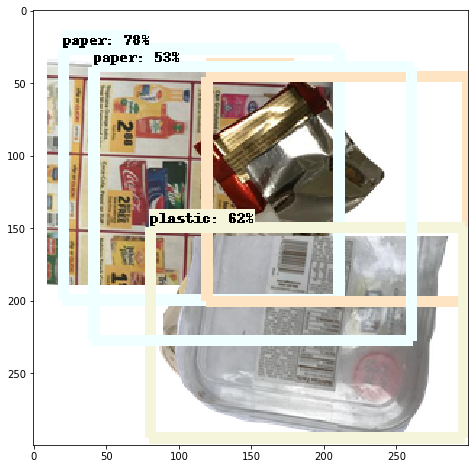

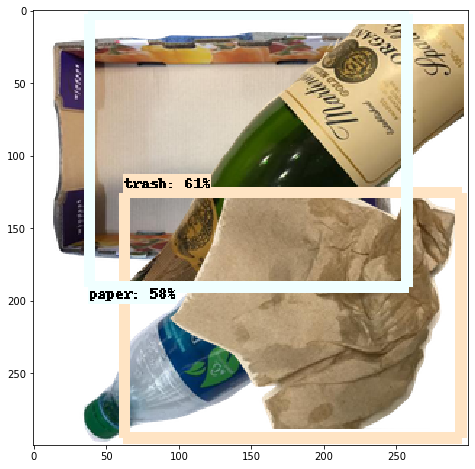

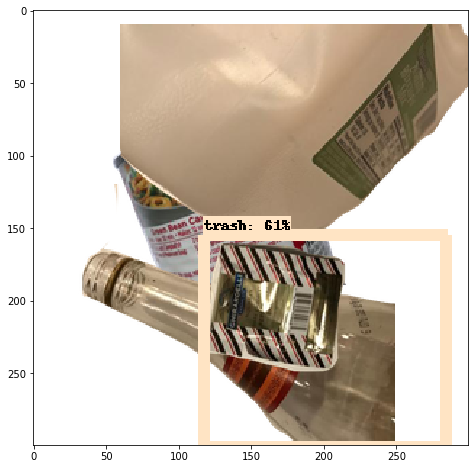

In [90]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import imageio

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height, channels) = image.shape
    return np.array(image).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    #image = Image.open(image_path)
    image_4 = imageio.imread(image_path)
    print(image_4.shape)
    image = image_4[:,:,:3]
    print(image.shape)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)